## import dependencies

In [2]:
landlab.__version__

'2.2.0'

In [61]:
import os
import numpy as np
from landlab import RasterModelGrid
import landlab
from landlab.io import read_esri_ascii
from landlab.components import FlowAccumulator, FastscapeEroder, SedDepEroder,LinearDiffuser, ErosionDeposition, DepressionFinderAndRouter
from landlab.io.esri_ascii import write_esri_ascii

In [62]:
def create_folder(name):
    parent_folder = "./save_asc"
    path = os.path.join(parent_folder, name)
    if not os.path.exists(path):
        os.mkdir(path)  

In [63]:
#create_folder("")

## import DEM

In [64]:
(mg_origin, z) = read_esri_ascii("./save_asc/testes/ascii_cropadotest.asc", name="topographic__elevation")

(mg, z) = read_esri_ascii("./save_asc/testes/ascii_cropadotest.asc", name="topographic__elevation")
mg.at_node.keys()

['topographic__elevation']

In [65]:
mg.BC_LINK_IS_FIXED
#mg.set_fixed_value_boundaries_at_grid_edges(right, top, left, bottom)
mg.set_fixed_value_boundaries_at_grid_edges(True, True, True, True)

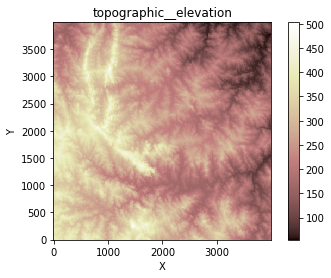

In [66]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation') 

In [67]:
#condiçoes de contorno
#mg.set_status_at_node_on_edges(right= mg.BC_NODE_IS_FIXED_VALUE, top=mg.BC_NODE_IS_FIXED_VALUE,
                               #left=mg.BC_NODE_IS_FIXED_VALUE, bottom=mg.BC_NODE_IS_FIXED_VALUE)
mg.set_status_at_node_on_edges(right= mg.BC_NODE_IS_FIXED_VALUE, top=mg.BC_NODE_IS_FIXED_VALUE,
                               left=mg.BC_NODE_IS_FIXED_VALUE, bottom=mg.BC_NODE_IS_FIXED_VALUE) 

In [68]:
mg.BC_NODE_IS_FIXED_VALUE

<NodeStatus.FIXED_VALUE: 1>

In [69]:
def return_grid():
    grid = mg.at_node['topographic__elevation'].reshape(400, 400)
    return grid
return_grid()

array([[ 400.,  402.,  405., ...,  171.,  184.,  197.],
       [ 402.,  408.,  408., ...,  174.,  184.,  200.],
       [ 406.,  410.,  412., ...,  174.,  188.,  194.],
       ..., 
       [ 212.,  206.,  211., ...,  106.,  100.,   91.],
       [ 205.,  211.,  218., ...,   97.,   91.,   89.],
       [ 211.,  214.,  226., ...,  101.,   92.,   92.]])

In [47]:
def apply_boundary(boundary):
    grid = mg.at_node['topographic__elevation'].reshape(400, 400)
    grid[0] = mg.BC_NODE_IS_FIXED_VALUE
    grid[-1] = mg.BC_NODE_IS_FIXED_VALUE
    grid[:,][0] = mg.BC_NODE_IS_FIXED_VALUE
    return grid

apply_boundary(mg.BC_NODE_IS_FIXED_VALUE)

array([[   1.,    1.,    1., ...,    1.,    1.,    1.],
       [ 402.,  408.,  408., ...,  174.,  184.,  200.],
       [ 406.,  410.,  412., ...,  174.,  188.,  194.],
       ..., 
       [ 212.,  206.,  211., ...,  106.,  100.,   91.],
       [ 205.,  211.,  218., ...,   97.,   91.,   89.],
       [   1.,    1.,    1., ...,    1.,    1.,    1.]])

## creating component

In [6]:
#recebe o input do usuario
fr = FlowAccumulator(mg, flow_director='D8') 
df = DepressionFinderAndRouter(mg)
# m in the stream power equation (power on drainage area).
sp = FastscapeEroder(mg, K_sp=0.0004, m_sp=0.5, n_sp=1.0, threshold_sp= 0.0) #k eh erodibilidade, usar 0.0004
##FastscapeEroder(grid, K_sp=0.001, m_sp=0.5, n_sp=1.0, threshold_sp=0.0, discharge_field='drainage_area', erode_flooded_nodes=True)
mg.at_node['topographic__elevation'][0] -= 0.2 #uplift, valor inicial era 0.001 taxa 
sd= SedDepEroder(mg)
ed = ErosionDeposition(
     mg,
     K=0.0004, # Erodibility for substrate (units vary). talvez a mesma do fast scape (valor anterior = 0.00001)
     v_s=0.001, # Effective settling velocity for chosen grain size metric [L/T].
     m_sp=0.5, # Discharge exponent (units vary) usar valores do fast scape (valor anterior = 0.5)
     n_sp = 1.0, #Slope exponent (units vary) usar valores do fast scape
     sp_crit=0) #Critical stream power to erode substrate [E/(TL^2)] usar valores do fast scape
#lin_diffuse = LinearDiffuser (mg, linear_diffusivity = 0.01)


In [7]:
mg.at_node['topographic__elevation']

array([ 399.8,  402. ,  405. , ...,  101. ,   92. ,   92. ])

### run components

In [8]:
# Create test folder name
test_name = 'erosion_deposition_uplift_0,001_18_8'
create_folder(test_name)

In [9]:
uplift_rate = 0.001
time_step = 1000 #time step linear diffuser component
fr.run_one_step()
sp.run_one_step(time_step) # atençao: apenas para rodar antes do erosion deposition
for i in range(10001):
    print(i)
    #fr.run_one_step()
    #sp.run_one_step(time_step) #dt eh multiplicador da formula e do threshold,
    df.map_depressions()
    flooded = np.where(df.flood_status==3)[0] # ver pra que serve
    ed.run_one_step(time_step)
    mg.at_node['topographic__elevation'] += time_step * uplift_rate
    #no artigo ele usa em anos mas esta de acordo com todos os outros parametros em anos tbm 
    #lin_diffuse.run_one_step(time_step) 
    if i ==1000  or i == 2000 or i == 4000 or i == 6000 or i == 8000 or i == 10000:
        files = write_esri_ascii("./save_asc/"+test_name+"/"+str(i)+".asc", mg)


0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [ ]:
mg.at_node.keys()

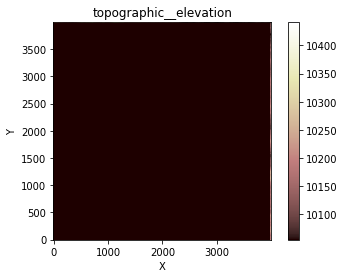

In [23]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation')

In [18]:
files = write_esri_ascii("./save_asc/ascii_fse_2.asc", mg) #salva DEM no formato ASCII, salva um arquivo por grid


In [20]:
(mg1, z) = read_esri_ascii("./save_asc/ascii_fse_1_topographic__elevation.asc", name="topographic__elevation")
mg1.at_node.keys()

['topographic__elevation']

In [21]:
landlab.plot.imshow.imshow_grid_at_node(mg1,'topographic__elevation') #range 5

NameError: name 'mg1' is not defined

In [37]:
(mg5, z) = read_esri_ascii("./save_asc/ascii_fse_30_topographic__steepest_slope.asc", name="topographic__elevation")
mg5.at_node.keys()

['topographic__elevation']

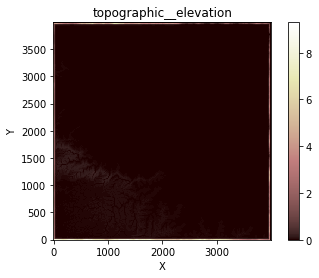

In [38]:
landlab.plot.imshow.imshow_grid_at_node(mg5,'topographic__elevation') #range 30